# Bayesian Autoregressive Model

1. Let's set up an AR-N with uncertainty quantification and benchmark it agains a packaged version, which only gives a prediction (but no uncertainty)

2. Let's compare maximal likelihood against fully uncertainty quantified Bayesian approach


So on ouptut we will have a distribution of possible next step of the time series

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as onp

import numpyro
from numpyro import sample
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer.reparam import TransformReparam

from tqdm import trange

from jax import random, jit, vmap
import jax.numpy as np

import arviz as az

from functools import partial

from scipy.special import logit, expit

sns.set_theme()
key = random.PRNGKey(0)


# Toy training data

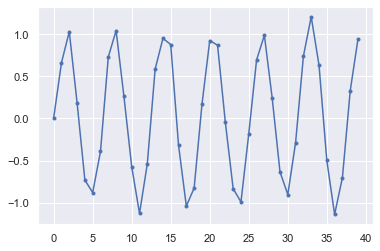

In [3]:
x = np.arange(0., 40)

# imitate return (which is oscillating around the mean)
y_dat = np.sin(x)+random.normal(key, (x.size,))*.1

%matplotlib inline
plt.plot(x, y_dat, '.-')

# Benchmark: maximal-likelihood using `statsmodels`

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

# number of lags
N_lag = 4
res = AutoReg(pd.Series(y_dat), lags = N_lag).fit()

res.params

/Users/peteryatsyshin/opt/anaconda3/envs/xeus/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


intercept    0.017913
y.L1         0.287535
y.L2        -0.391551
y.L3        -0.515867
y.L4        -0.252868
dtype: float64

[0.017912527979108833,
 -0.2528676572308417,
 -0.5158669956696658,
 -0.39155085924487787,
 0.287535205492064]

## Visualise maximal likelihood prediction

In [41]:
a = np.array([res.params['intercept']]+[res.params[f"y.L{i}"] for i in range(N_lag, 0, -1)])

In [5]:
a = np.array([res.params['intercept'], res.params['y.L2'], res.params['y.L1']])

In [39]:
y0

DeviceArray([0.0059049 , 0.66257054, 1.0320855 , 0.18703026], dtype=float32)

In [40]:
a

[0.017912527979108833,
 -0.2528676572308417,
 -0.5158669956696658,
 -0.39155085924487787,
 0.287535205492064]

In [42]:
Ns = 10
Y = y_dat[-1][None]

y0 = y_dat[:N_lag]
for i in range(Ns):
    m_t = a[0]+a[1:] @ y0
    Y = np.concatenate([Y, m_t[None]])
    y0 = np.concatenate([y0[1:], m_t[None]])

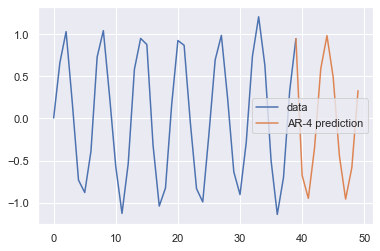

In [44]:
plt.plot(x,y_dat)
plt.plot(np.arange(x[-1], x[-1]+Ns+1), Y);

plt.legend(['data', f'AR-{N_lag} prediction']);

# Bayesian AR-N

Above we get a pointwise prediction for `Ns` steps into the future. These predictions do not include any uncertainty. What we want is the model to tell us how confident it is in each future step. We can achieve this by placing prior distributions on model parameters and MC-sampling from the posterior. 

In orhter words, let's set up the model in a way, which quantifies uncertainty and gives a "spread" of possible predictions

In [45]:
def arN_infer(N, y=None):
    """
    Inference AR-N model
    N - order of AR-N
    y - data
    """
    a = sample("a", dist.Normal().expand([N+1]))
    sigma = sample("sigma", dist.HalfNormal(1.))
    
    
    def transition(y_prev, _):
        m_t = a[0] + a[1:] @ y_prev
        y_t = sample("y", dist.Normal(m_t, sigma))
        y_curr = np.concatenate([y_prev[1:], y_t[None]])
        return y_curr, None

    with numpyro.handlers.condition(data={"y": y[N:]}):
        scan(transition, y[:N], np.arange(len(y)-N))


In [46]:
def arN_predict(y0, num_steps):
    """
    Predictive AR-N model. Order is N, given by size of y0. Will run for num_steps
    
    """
    
    N = len(y0)
    
    a = sample("a", dist.Normal().expand([N+1]))
    sigma = sample("sigma", dist.HalfNormal(1.))
    
    
    def transition(y_prev, _):
        m_t = a[0] + a[1:] @ y_prev
        y_t = sample("y", dist.Normal(m_t, sigma))
        y_curr = np.concatenate([y_prev[1:], y_t[None]])
        return y_curr, y_t

    # Start with y0, run AR-N forward, iterating for num_steps
    _, dump = scan(transition, y0, np.arange(num_steps))
    
    return dump

## Train the model

As said, training is via MCMC sampling. In this case posterior is easy. The result is a sample of our set of parameters in batched vector `a`

In [47]:
kernel = NUTS(arN_infer, max_tree_depth=10, dense_mass=False)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

In [48]:
mcmc.run(key, N_lag, y = y_dat)

sample: 100%|█| 2000/2000 [00:02<00:00, 734.80it/s, 31 steps of size 9.17e-02. a


In [50]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.02      0.02      0.02     -0.01      0.05    633.99      1.00
      a[1]     -0.27      0.18     -0.27     -0.56     -0.00    376.17      1.00
      a[2]     -0.52      0.15     -0.52     -0.77     -0.27    345.03      1.00
      a[3]     -0.38      0.15     -0.39     -0.62     -0.12    336.85      1.00
      a[4]      0.26      0.18      0.27     -0.03      0.55    337.80      1.00
     sigma      0.12      0.02      0.12      0.10      0.15    611.69      1.00

Number of divergences: 0


## Compare Bayesian mean against maximal likelihood estimator 

Note that in our setup: 
* a[0] is intercept, 
* a[1] is lag 2,
* a[2] is lag 1

We see that the mean is exactly the same as the maximal likelihood, obtained with another package, which is just a sanity check for our Bayesian model. 

In [51]:
res.params

intercept    0.017913
y.L1         0.287535
y.L2        -0.391551
y.L3        -0.515867
y.L4        -0.252868
dtype: float64

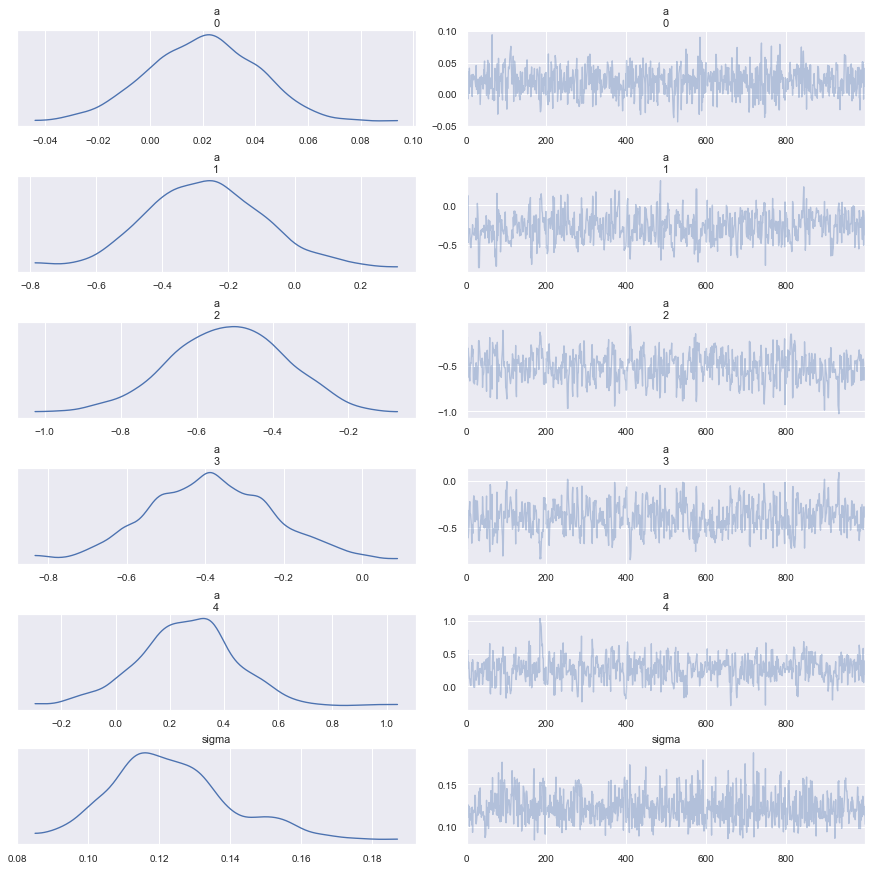

In [52]:
az.plot_trace(az.from_numpyro(mcmc), compact=False);

## Make prediction

In [53]:
predictive = Predictive(arN_predict, mcmc.get_samples())

In [54]:
key1, key = random.split(key)
Nsteps = 10 
d = predictive(key1, y_dat[-N_lag:], Nsteps)

In [55]:
d['y'].shape

(1000, 10)

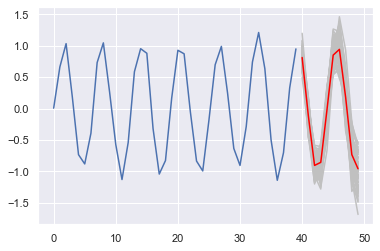

In [59]:

l1 = plt.plot(np.arange(x[-1]+1, x[-1]+Nsteps+1), d['y'][::10].T, color = 'silver');
l2 = plt.plot(np.arange(x[-1]+1, x[-1]+1+Nsteps), d['y'].mean(axis = 0), color = 'red');
l0 = plt.plot(x, y_dat);